# Análisis de e-commerce

Integrantes:
- Antonio Eugenio Daniel
- Domínguez Espinoza Juan Pablo

Este es un conjunto de datos transnacional que contiene todas las transacciones ocurridas entre el 01/12/2010 y el 09/12/2011 para una empresa minorista en línea sin tienda física registrada y con sede en el Reino Unido. La empresa vende principalmente regalos únicos para cualquier ocasión. Muchos clientes de la empresa son mayoristas

https://www.kaggle.com/datasets/carrie1/ecommerce-data/data

# 1. Limpieza y Preprocesamiento de Datos

En esta sección abordamos los requisitos fundamentales de calidad de datos. Realizamos las siguientes acciones:
1.  **Conversión de Fechas:** Transformamos `InvoiceDate` a formato datetime para análisis temporales.
2.  **Eliminación de Duplicados:** Aseguramos que no haya registros repetidos que inflen las ventas.
3.  **Manejo de Devoluciones:** Las facturas que inician con 'C' son cancelaciones. Las separamos para no afectar el cálculo de ingresos netos.
4.  **Tratamiento de Nulos:** Eliminamos registros sin `CustomerID` ya que son necesarios para la segmentación de clientes, aunque mantenemos el dataset original si se requiriera análisis global anónimo.
5.  **Ingeniería de Características:** Creamos la variable `TotalAmount` (Cantidad * Precio Unitario).

In [6]:
import pandas as pd
import numpy as np

df = pd.read_csv('data.csv', encoding='ISO-8859-1')

# 1. Corrección de tipos
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 2. Eliminar duplicados
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"Filas duplicadas eliminadas: {initial_rows - df.shape[0]}")

# 3. Separar devoluciones y filtrar
df_devoluciones = df[df['InvoiceNo'].astype(str).str.contains('C')]
df_limpio = df[~df['InvoiceNo'].astype(str).str.contains('C')]

# Filtros de coherencia (Cantidades positivas y precios mayores a 0)
df_limpio = df_limpio[(df_limpio['Quantity'] > 0) & (df_limpio['UnitPrice'] > 0)]

# 4. Manejo de nulos (Enfoque en clientes identificables)
df_limpio.dropna(subset=['CustomerID'], inplace=True)
df_limpio['CustomerID'] = df_limpio['CustomerID'].astype(int)

# 5. Variable derivada
df_limpio['TotalAmount'] = df_limpio['Quantity'] * df_limpio['UnitPrice']

print(f"Dataset listo para análisis: {df_limpio.shape}")
df_limpio.head()

Filas duplicadas eliminadas: 5268
Dataset listo para análisis: (392692, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


# 1.1. Comparativa de Técnicas de Suavizado y Reducción de Ruido

Antes de proceder al análisis de componentes periódicos, es necesario reducir la volatilidad diaria de las ventas para observar mejor las tendencias subyacentes.

Evaluamos tres estrategias de filtrado para determinar cuál preserva mejor la señal sin introducir retardos significativos:

1.  **Medias Móviles (Enfoque Clásico):** Suavizado estadístico mediante ventanas de tiempo (7 días para ciclo semanal y 30 días para tendencia mensual).
2.  **Filtrado FFT (Enfoque Espectral):** Eliminación de frecuencias altas utilizando la Transformada de Fourier (se profundizará en este método en la siguiente sección).
3.  **Reconstrucción PCA (Enfoque Matricial):** Uso de Análisis de Componentes Principales sobre ventanas deslizantes para reconstruir la señal basándose en su varianza principal.

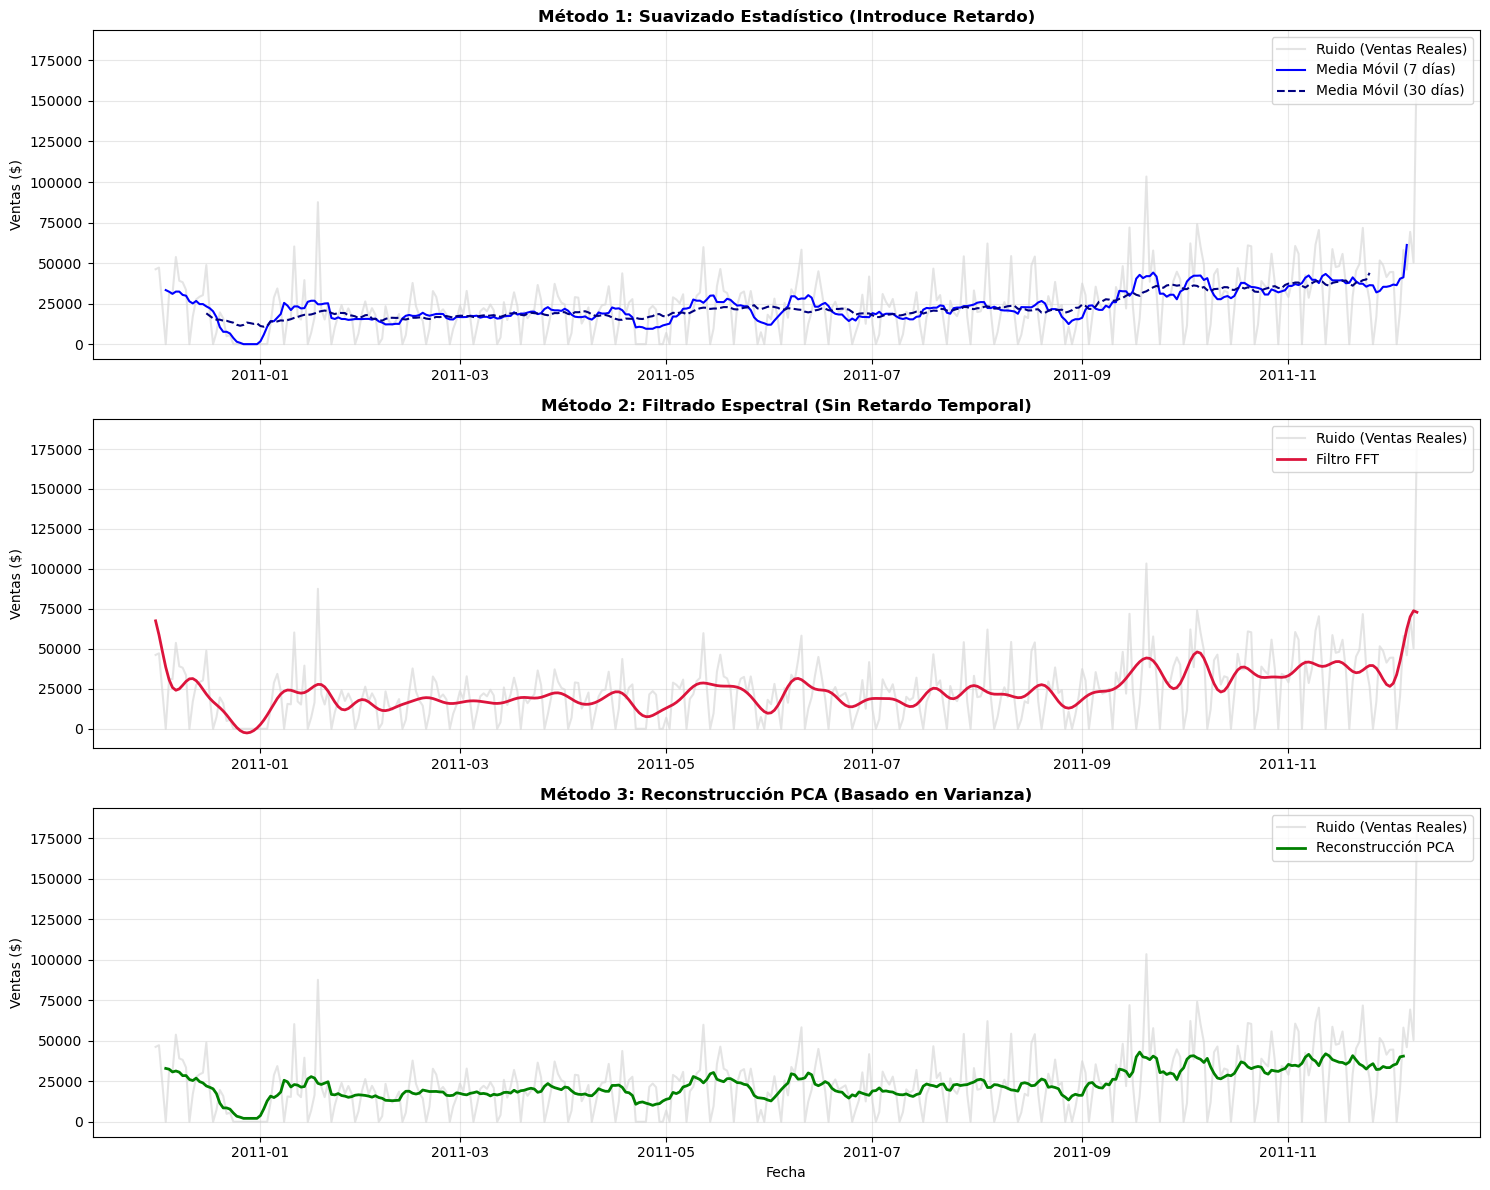

In [7]:
import matplotlib.pyplot as plt
from scipy import fftpack
from sklearn.decomposition import PCA

# 1. Preparación de la Serie de Tiempo
# Agrupamos por día y rellenamos días faltantes con 0
daily_sales = df_limpio.set_index('InvoiceDate').resample('D')['TotalAmount'].sum().fillna(0)
signal = daily_sales.values

# MÉTODO A: Medias Móviles (Moving Averages)
# Ventana de 7 días (Suavizado de ciclo semanal)
ma_7 = daily_sales.rolling(window=7, center=True).mean()
# Ventana de 30 días (Tendencia mensual)
ma_30 = daily_sales.rolling(window=30, center=True).mean()

# MÉTODO B: Filtro FFT (Adelanto del Análisis Espectral)
def filter_fft(signal_1d, threshold=0.1):
    sig_fft = fftpack.fft(signal_1d)
    freqs = fftpack.fftfreq(signal_1d.size, d=1)
    # Filtro Pasa-Bajos: eliminamos ruido de alta frecuencia
    sig_fft[np.abs(freqs) > threshold] = 0
    return np.real(fftpack.ifft(sig_fft))

denoised_fft = filter_fft(signal, threshold=0.1)

# MÉTODO C: Reconstrucción PCA (Denoising)
def filter_pca(series, w=7):
    # 1. Crear matriz de ventanas deslizantes
    # Nota: Usamos len(series)-w para asegurar ventanas completas
    data = [series[i:i+w] for i in range(len(series)-w)]
    
    # 2. Proyectar al primer componente principal
    pca = PCA(n_components=1)
    reconstruction = pca.inverse_transform(pca.fit_transform(data))
    
    # 3. Alinear resultado (CORRECCIÓN ROBUSTA)
    result = np.full(len(series), np.nan)
    
    # En lugar de hardcodear el slice negativo (ej: -4), 
    # calculamos el final basándonos en el tamaño real de la reconstrucción
    n_samples = reconstruction.shape[0]  # Esto es 367 en tu caso
    start_idx = w // 2                   # Offset inicial (ej: 3)
    end_idx = start_idx + n_samples      # Offset final exacto
    
    # Asignación segura
    result[start_idx : end_idx] = reconstruction[:, w//2]
    
    return result

denoised_pca = filter_pca(signal, w=7)

plt.figure(figsize=(15, 12)) # Hacemos la figura más alta

# --- Gráfico 1: Medias Móviles ---
plt.subplot(3, 1, 1) # (3 filas, 1 columna, gráfico #1)
plt.plot(daily_sales.index, daily_sales, color='lightgray', label='Ruido (Ventas Reales)', alpha=0.6)
plt.plot(daily_sales.index, ma_7, color='blue', linewidth=1.5, label='Media Móvil (7 días)')
plt.plot(daily_sales.index, ma_30, color='navy', linestyle='--', linewidth=1.5, label='Media Móvil (30 días)')
plt.title('Método 1: Suavizado Estadístico (Introduce Retardo)', fontsize=12, fontweight='bold')
plt.ylabel('Ventas ($)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# --- Gráfico 2: Filtro FFT ---
plt.subplot(3, 1, 2) # (3 filas, 1 columna, gráfico #2)
plt.plot(daily_sales.index, daily_sales, color='lightgray', label='Ruido (Ventas Reales)', alpha=0.6)
plt.plot(daily_sales.index, denoised_fft, color='crimson', linewidth=2, label='Filtro FFT')
plt.title('Método 2: Filtrado Espectral (Sin Retardo Temporal)', fontsize=12, fontweight='bold')
plt.ylabel('Ventas ($)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# --- Gráfico 3: PCA ---
plt.subplot(3, 1, 3) # (3 filas, 1 columna, gráfico #3)
plt.plot(daily_sales.index, daily_sales, color='lightgray', label='Ruido (Ventas Reales)', alpha=0.6)
plt.plot(daily_sales.index, denoised_pca, color='green', linewidth=2, label='Reconstrucción PCA')
plt.title('Método 3: Reconstrucción PCA (Basado en Varianza)', fontsize=12, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Ventas ($)')
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Análisis Espectral y Componentes Periódicos

Tras evaluar distintos métodos de suavizado en la sección anterior, determinamos que la **Transformada de Fourier (FFT)** es la herramienta más efectiva para nuestro análisis, ya que nos permite aislar patrones sin introducir el retardo temporal (*lag*) inherente a las medias móviles.

En esta sección profundizamos en el análisis espectral para descomponer matemáticamente la estacionalidad de las ventas:

1.  **Preparación de la Señal:** Agregamos las ventas por día y rellenamos los días inactivos con 0 para garantizar una continuidad temporal estricta.
2.  **Transformación al Dominio de la Frecuencia:** Aplicamos la FFT para convertir nuestra serie de tiempo (dominio temporal) en un espectro de frecuencias.
3.  **Detección de Ciclos:** Identificamos los "picos" de amplitud en el espectro. Esto nos revela matemáticamente la existencia de ciclos repetitivos (como patrones semanales de 7 días) que podrían quedar ocultos o distorsionados bajo el ruido aleatorio si solo usáramos métodos visuales o estadísticos simples.

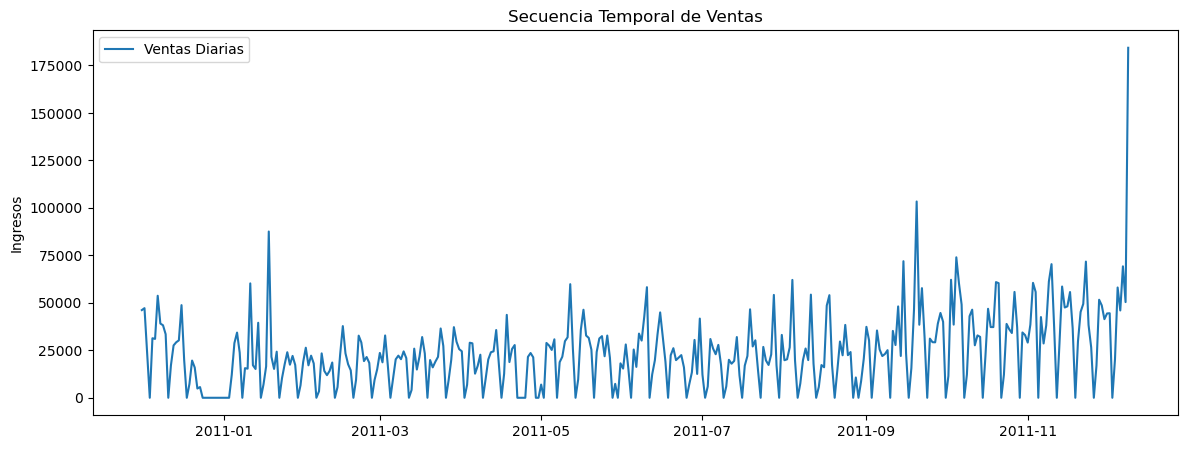

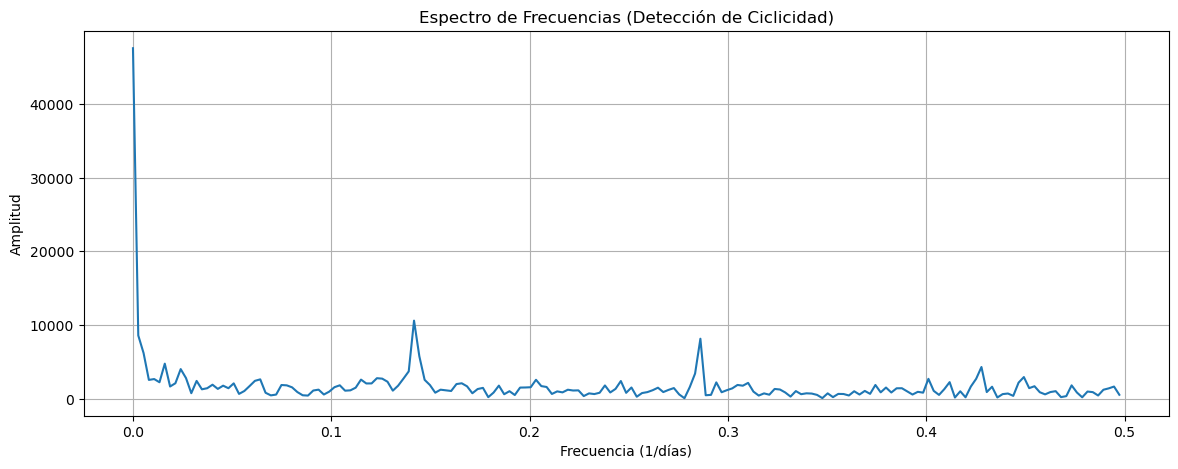

In [8]:
from scipy.fft import fft, fftfreq

# 1. Agregar ventas por día
ts_data = df_limpio.groupby(df_limpio['InvoiceDate'].dt.date)['TotalAmount'].sum()
ts_data.index = pd.to_datetime(ts_data.index)
ts_data = ts_data.asfreq('D').fillna(0)

# Visualización de la serie
plt.figure(figsize=(14, 5))
plt.plot(ts_data, label='Ventas Diarias')
plt.title('Secuencia Temporal de Ventas')
plt.ylabel('Ingresos')
plt.legend()
plt.show()

# 2. Análisis Espectral (FFT)
n = len(ts_data)
yf = fft(ts_data.values)
xf = fftfreq(n, 1) # Muestreo diario (T=1)

# Graficar el espectro de frecuencias
plt.figure(figsize=(14, 5))
plt.plot(xf[:n//2], 2.0/n * np.abs(yf[0:n//2]))
plt.title('Espectro de Frecuencias (Detección de Ciclicidad)')
plt.xlabel('Frecuencia (1/días)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

# 3. Análisis Exploratorio de Datos (EDA)

Antes de modelar, exploramos las características principales del negocio:
1.  **Distribución de Variables:** Analizamos histogramas de precios y cantidades para entender la dispersión.
2.  **Top Productos:** Identificamos los artículos más rentables (Principio de Pareto).
3.  **Análisis Geográfico:** Visualizamos qué países aportan más ingresos.

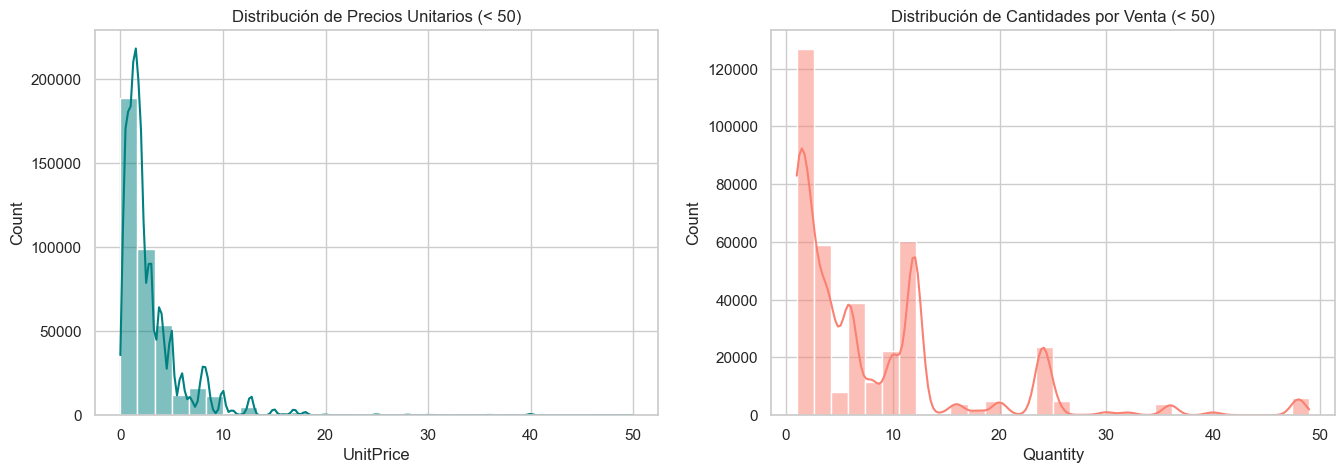

C:\Users\furho\AppData\Local\Temp\ipykernel_27284\2818090991.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')


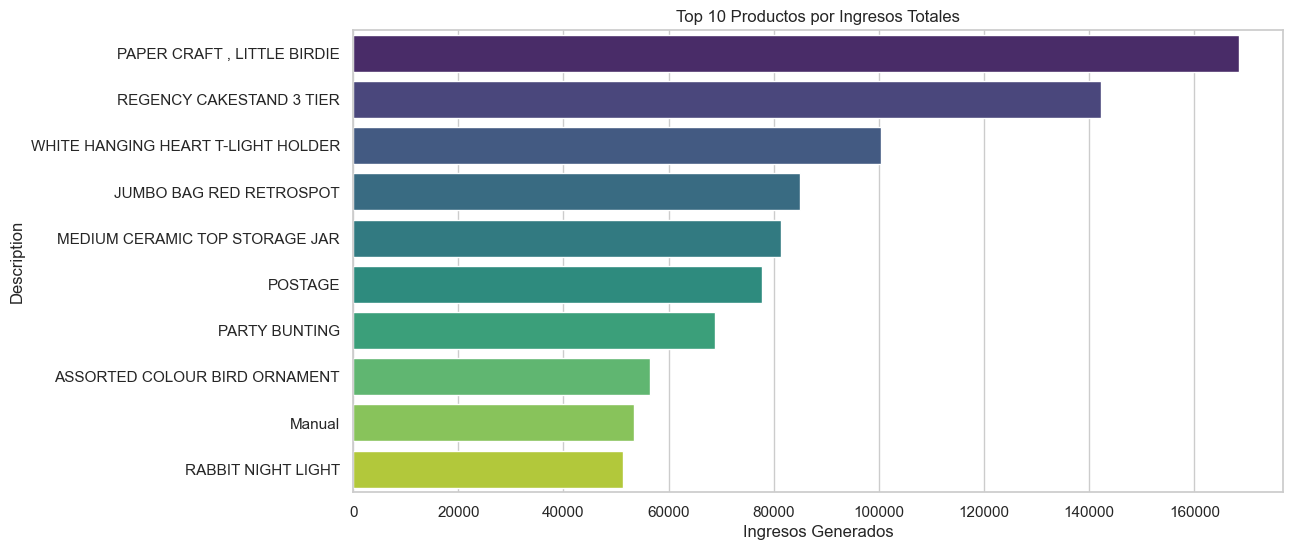

C:\Users\furho\AppData\Local\Temp\ipykernel_27284\2818090991.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sales_no_uk.values, y=sales_no_uk.index, palette='magma')


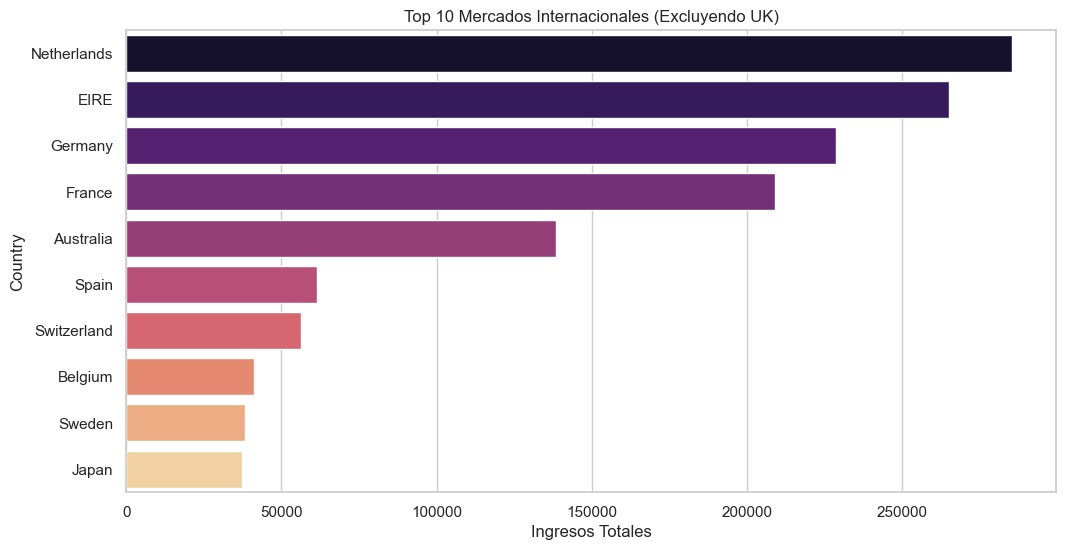

In [9]:
import seaborn as sns

# Configuración estética
sns.set(style="whitegrid")

# 1. Distribución de Precio y Cantidad (Filtrando extremos para visualización)
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Precio Unitario (Log para mejor visualización)
sns.histplot(df_limpio[df_limpio['UnitPrice'] < 50]['UnitPrice'], bins=30, kde=True, ax=ax[0], color='teal')
ax[0].set_title('Distribución de Precios Unitarios (< 50)')

# Cantidad
sns.histplot(df_limpio[df_limpio['Quantity'] < 50]['Quantity'], bins=30, kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Distribución de Cantidades por Venta (< 50)')
plt.show()

# 2. Top 10 Productos más rentables
top_products = df_limpio.groupby('Description')['TotalAmount'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_products.values, y=top_products.index, palette='viridis')
plt.title('Top 10 Productos por Ingresos Totales')
plt.xlabel('Ingresos Generados')
plt.show()

# 3. Ventas por País (Excluyendo UK para ver mejor el resto, ya que UK domina)
sales_country = df_limpio.groupby('Country')['TotalAmount'].sum().sort_values(ascending=False)
# Separamos UK para el gráfico si es muy dominante
sales_no_uk = sales_country.drop('United Kingdom', errors='ignore').head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=sales_no_uk.values, y=sales_no_uk.index, palette='magma')
plt.title('Top 10 Mercados Internacionales (Excluyendo UK)')
plt.xlabel('Ingresos Totales')
plt.show()

# 4. Segmentación de Clientes con Modelo RFM y K-Means

Implementamos una segmentación no supervisada basada en el comportamiento del cliente:
* **Recency (R):** Días desde la última compra.
* **Frequency (F):** Número de compras totales.
* **Monetary (M):** Dinero total gastado.

**Metodología:**
1.  Calculamos las métricas RFM por cliente.
2.  Aplicamos transformación logarítmica para manejar la asimetría de los datos (skewness).
3.  Estandarizamos las variables para que tengan media 0 y desviación estándar 1.
4.  Utilizamos el **Método del Codo** para decidir el número óptimo de clusters.
5.  Aplicamos **K-Means** para asignar grupos.

c:\Users\furho\.conda\envs\escom_5\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


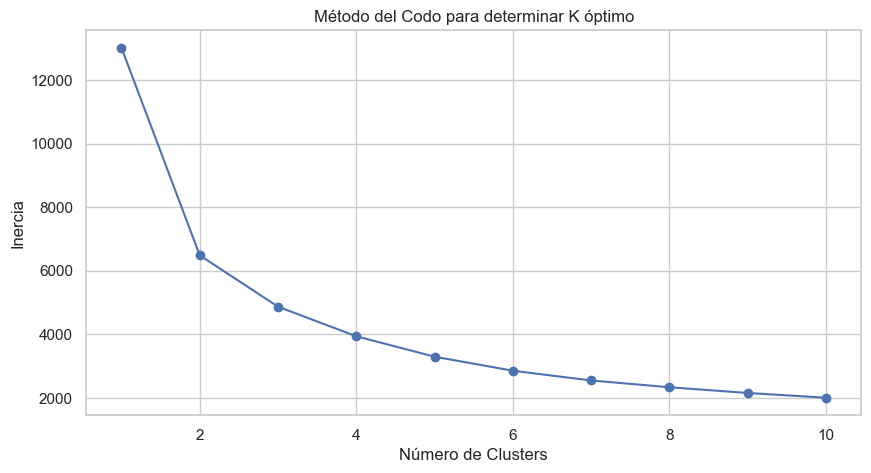

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# 1. Construcción de matriz RFM
fecha_ref = df_limpio['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df_limpio.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (fecha_ref - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalAmount': 'Monetary'})

# 2. Preprocesamiento (Log + Scaling)
rfm_log = np.log1p(rfm)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

# 3. Método del Codo
inercia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(K_range, inercia, marker='o')
plt.title('Método del Codo para determinar K óptimo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inercia')
plt.show()

# 4. Aplicar K-Means (Ajustar n_clusters según el gráfico anterior, usaremos 3 por defecto)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# 5. Análisis de Dependencia y Correlación

Evaluamos la relación entre las variables numéricas clave para detectar patrones o redundancias:
1.  **Matriz de Correlación (Pearson):** Mide la relación lineal.
2.  **Matriz de Correlación (Spearman):** Mide la relación monotónica (de rango), útil si los datos no son normales.
3.  **Relaciones entre variables RFM:** Visualizamos cómo interactúan la Recencia, Frecuencia y Monto.

Correlación Transaccional:
             Quantity  UnitPrice  TotalAmount
Quantity     1.000000  -0.004578     0.914451
UnitPrice   -0.004578   1.000000     0.081619
TotalAmount  0.914451   0.081619     1.000000


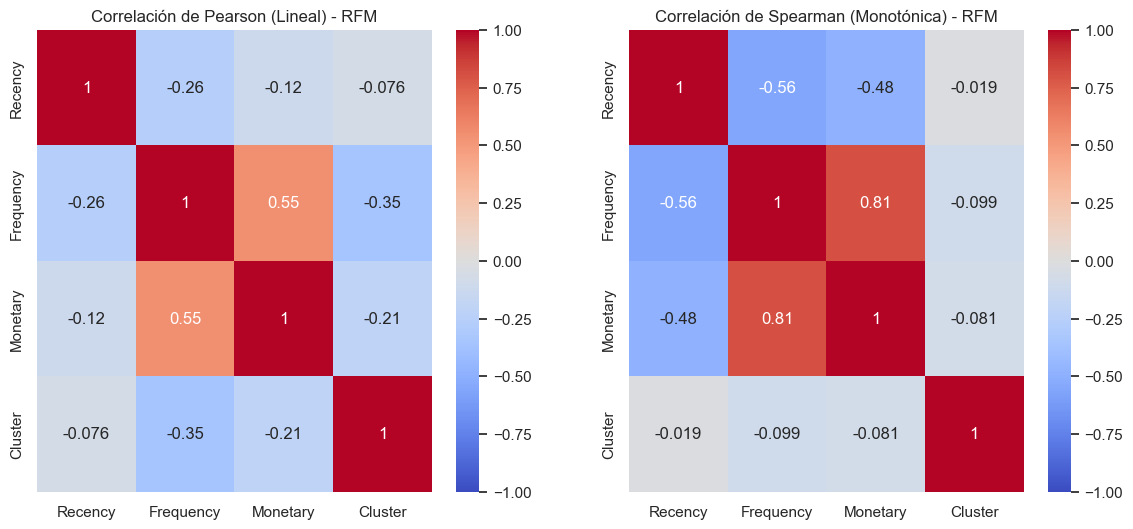

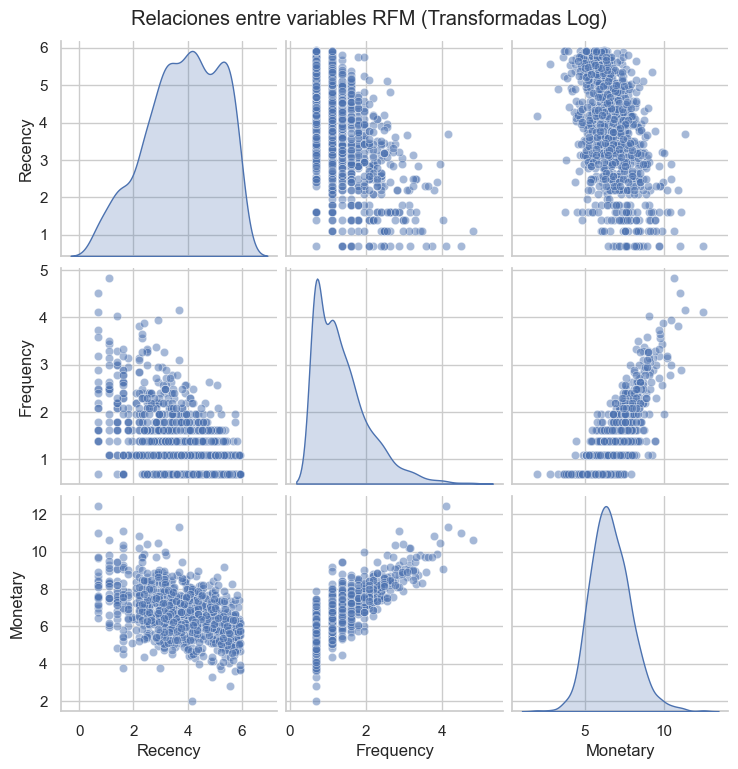

In [11]:
# Usaremos el dataframe 'rfm' para analizar clientes,
# y df_limpio para analizar transacciones.

# 1. Correlación en Transacciones (Cantidad vs Precio)
print("Correlación Transaccional:")
print(df_limpio[['Quantity', 'UnitPrice', 'TotalAmount']].corr())

# 2. Correlación en Comportamiento de Clientes (RFM)
# Pearson (Lineal)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.heatmap(rfm.corr(method='pearson'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación de Pearson (Lineal) - RFM')

# Spearman (Monotónica - mejor para datos sesgados)
plt.subplot(1, 2, 2)
sns.heatmap(rfm.corr(method='spearman'), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlación de Spearman (Monotónica) - RFM')
plt.show()

# 3. Visualización de Relaciones (Pairplot)
# Usamos una muestra para no saturar el gráfico
sns.pairplot(rfm_log.sample(1000, random_state=42), kind='scatter', diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Relaciones entre variables RFM (Transformadas Log)', y=1.02)
plt.show()

# 6. Proyección y Reducción de Dimensionalidad (PCA)

Dado que trabajamos con múltiples dimensiones (R, F, M), utilizamos **Análisis de Componentes Principales (PCA)** para proyectar los datos en un espacio 2D.

Esto nos permite:
1.  Visualizar la separación entre los clusters encontrados anteriormente.
2.  Validar visualmente la calidad del agrupamiento.
3.  Entender la varianza explicada por los componentes principales.

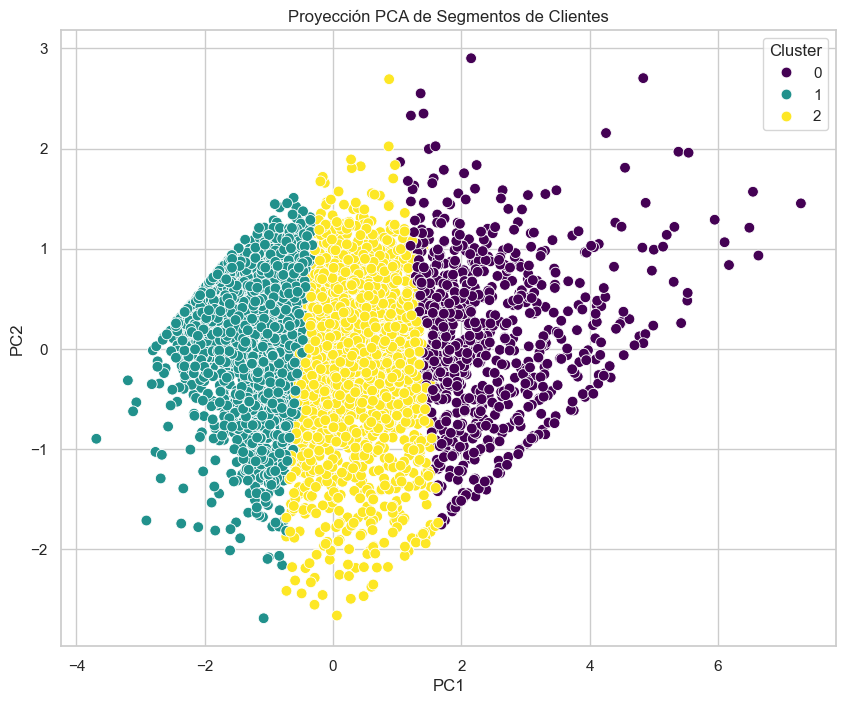

Varianza explicada por PC1 y PC2: [0.75078634 0.18786648]


In [12]:
# 1. Aplicar PCA
pca = PCA(n_components=2)
components = pca.fit_transform(rfm_scaled)

# Crear DataFrame para graficar
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = rfm['Cluster'].values

# 2. Visualización 2D
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=60)
plt.title('Proyección PCA de Segmentos de Clientes')
plt.show()

# 3. Varianza explicada
print(f"Varianza explicada por PC1 y PC2: {pca.explained_variance_ratio_}")

# 7. Discretización de Variables

Para simplificar el análisis o crear reglas de negocio, convertimos variables continuas en categorías (bins).
Ejemplo: Clasificar a los clientes según su gasto (`Monetary`) en niveles: Bajo, Medio, Alto.

Distribución de Clientes por Nivel de Lealtad:
Loyalty_Level
Bronce    1446
Plata     1446
Oro       1446
Name: count, dtype: int64


C:\Users\furho\AppData\Local\Temp\ipykernel_27284\1443299742.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Loyalty_Level', y='Recency', data=rfm, palette='Set2')


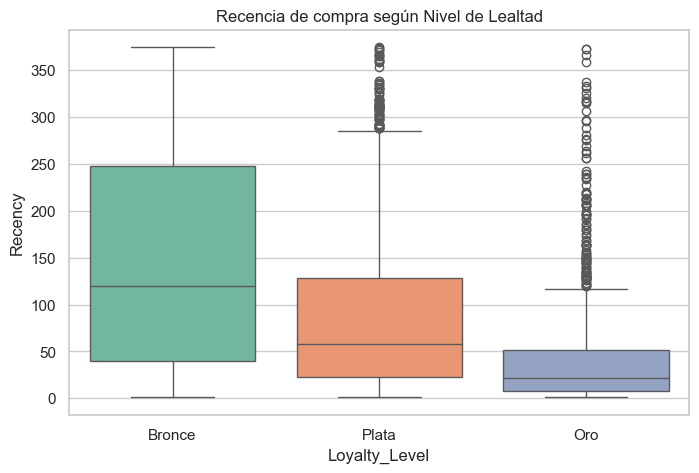

In [13]:
# Usamos qcut para cortar por cuantiles (asegura misma cantidad de gente por grupo)
# o cut para cortar por valores fijos.

# Crear 3 categorías de valor de cliente: Bronce, Plata, Oro
labels = ['Bronce', 'Plata', 'Oro']
rfm['Loyalty_Level'] = pd.qcut(rfm['Monetary'], q=3, labels=labels)

print("Distribución de Clientes por Nivel de Lealtad:")
print(rfm['Loyalty_Level'].value_counts())

# Visualizar diferencias de Recencia por Nivel de Lealtad
plt.figure(figsize=(8, 5))
sns.boxplot(x='Loyalty_Level', y='Recency', data=rfm, palette='Set2')
plt.title('Recencia de compra según Nivel de Lealtad')
plt.show()

# 8. Integración de Resultados y Exportación para Tableau

Dado que la visualización final se realizará en Tableau, necesitamos exportar un dataset enriquecido que contenga:
1.  Las transacciones originales limpias.
2.  Las nuevas variables derivadas (TotalAmount).
3.  **El Segmento (Cluster)** al que pertenece cada cliente (resultado del modelo K-Means).

Esto permitirá en Tableau filtrar ventas, analizar tendencias y mapas geográficos segmentados por el tipo de cliente (VIP, Riesgo, Nuevos, etc.).

In [14]:
# 1. Unir los Clusters al dataset transaccional principal
# El dataframe 'rfm' tiene el índice 'CustomerID' y la columna 'Cluster'
# Hacemos un merge con df_limpio usando 'CustomerID' como llave
df_tableau = df_limpio.merge(rfm[['Cluster']], on='CustomerID', how='left')

# 2. Renombrar los clusters para que sean legibles en Tableau
map_clusters = {0: 'Clientes Frecuentes', 1: 'Clientes en Riesgo', 2: 'Alto Valor'}
df_tableau['Cluster_Label'] = df_tableau['Cluster'].map(map_clusters)

print("Vista previa del dataset final para Tableau:")
print(df_tableau[['InvoiceNo', 'CustomerID', 'TotalAmount', 'Cluster']].head())

# 3. Exportar a CSV
df_tableau.to_csv('Ecommerce_Data_Tableau.csv', index=False)

print(f"\nArchivo 'Ecommerce_Data_Tableau.csv' generado exitosamente con {df_tableau.shape[0]} filas.")

Vista previa del dataset final para Tableau:
  InvoiceNo  CustomerID  TotalAmount  Cluster
0    536365       17850        15.30        0
1    536365       17850        20.34        0
2    536365       17850        22.00        0
3    536365       17850        20.34        0
4    536365       17850        20.34        0

Archivo 'Ecommerce_Data_Tableau.csv' generado exitosamente con 392692 filas.
